## Import

In [1]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

In [19]:
# pip freeze
# pip freeze > requirements.txt
# pip install requirements.txt

In [1]:
pip freeze

absl-py==0.15.0
alabaster==0.7.12
alembic @ file:///home/conda/feedstock_root/build_artifacts/alembic_1622150326904/work
altair==4.1.0
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1624539388359/work/dist
appdirs @ file:///home/conda/feedstock_root/build_artifacts/appdirs_1603108395799/work
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1610522573621/work
astunparse==1.6.3
async-generator==1.10
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1620387926260/work
Babel @ file:///home/conda/feedstock_root/build_artifacts/babel_1619719576210/work
backcall @ file:///home/conda/feedstock_root/build_artifacts/backcall_1592338393461/work
backports.functools-lru-cache @ file:///home/conda/feedstock_root/build_artifacts/backports.functools_lru_cache_1618230623929/work
beautifulsoup4 @ file:///home/conda/feedstock_root/build_artifacts/beautifulsoup4_1601745390275/work
bleach @ file:///home/conda/feedstock_root/build_artifacts/bleach_16

Note: you may need to restart the kernel to use updated packages.


In [29]:
%config InlineBackend.figure_format = 'retina' # For high-resolution.
import pandas as pd
import numpy as np
import pydicom as dicom
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import os

import torch 
from torch import Tensor
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torch.optim import Adam


import cv2
from tqdm.notebook import tqdm


import warnings
warnings.filterwarnings('ignore')

import segmentation_models_pytorch as smp

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from scipy.stats import pearsonr
from sklearn.metrics import confusion_matrix


## Hyperparameters

In [20]:
## Hyperparameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
print(torch.cuda.device_count())

RESOLUTION = 256
BATCH_SIZE = 4
NUM_WORKERS = 4
PIN_MEMORY = True
DROP_LAST = True

LEARNING_RATE = 1e-4
NUM_EPOCHS = 3



cuda
1


## Create Data Frames

In [3]:
def read_df(df_type):
    username = os.getcwd().split('/')[2]
    df_path = '/home/{}/teams/dsc-180a---a14-[88137]/CANDID_PTX_csv/{}.csv'.format(username, df_type)
    df = pd.read_csv(df_path)[['Mask_Path', 'XRay_Path']]
    df['Mask_Path'] = df['Mask_Path'].str.replace('anw008', username)
    df['XRay_Path'] = df['XRay_Path'].str.replace('anw008', username)
    
    return df

In [4]:
train_df = read_df('train')
val_df = read_df('validation')
test_df = read_df('test')

## Creat Datasets & Dataloaders

In [33]:
class CANDID_PTX(Dataset):
    def __init__(self, df, resolution):
        self.img_paths = df['XRay_Path'].values
        self.mask_paths = df['Mask_Path'].values
        
        self.resolution = resolution
          
        return
            
    
    def __len__(self):
        
        return self.img_paths.shape[0]
    
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = dicom.dcmread(img_path).pixel_array
        img_min = np.min(img)
        img_max = np.max(img)
        img_norm = (img - img_min) / (img_max - img_min)
        img_norm = cv2.resize(img_norm, (self.resolution, self.resolution))
        img_norm = torch.tensor(img_norm).expand(3, self.resolution, self.resolution)
        
        mask_path = self.mask_paths[idx]
        mask = plt.imread(mask_path)[:, :, 0]
        mask = cv2.resize(mask, (self.resolution, self.resolution))
        mask = torch.tensor(mask).expand(1, self.resolution, self.resolution) 
        
        return img_norm, mask

In [34]:
train_ds = CANDID_PTX(train_df, RESOLUTION)
val_ds = CANDID_PTX(val_df, RESOLUTION)
test_ds = CANDID_PTX(test_df, RESOLUTION)

In [35]:
train_loader = DataLoader(train_ds, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, 
                          pin_memory = PIN_MEMORY, drop_last = DROP_LAST, shuffle = True)

val_loader = DataLoader(val_ds, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, 
                          pin_memory = PIN_MEMORY, drop_last = DROP_LAST, shuffle = False)

test_loader = DataLoader(test_ds, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, 
                          pin_memory = PIN_MEMORY, drop_last = DROP_LAST, shuffle = False)


## Train UNET

In [9]:
model = smp.Unet("resnet34", encoder_weights="imagenet", in_channels = 3, classes=1, activation=None)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/xdg-cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [10]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [11]:
def training(model, num_epochs, batch_size, learning_rate, 
                    train_loader, val_loader):
    
    model.to(DEVICE)
    
    all_train_loss = []
    all_val_loss = []
    all_preds = []
    all_masks = []
    
    optimizer = Adam(model.parameters(), lr=learning_rate)
    loss_fn = torch.nn.BCEWithLogitsLoss()
    scaler = torch.cuda.amp.GradScaler()
    
    for epoch in tqdm(range(num_epochs)):
        total_train_loss = 0
        batch_num = 0
        model.train()
        
        for i, (imgs, masks) in enumerate(train_loader):
            batch_num += 1
            
            imgs, masks = imgs.to(DEVICE, dtype=torch.float), masks.to(DEVICE, dtype=torch.float)
            
            optimizer.zero_grad()
            preds = model(imgs)
            if i == 0:
                all_preds.append(preds.detach().cpu())
                all_masks.append(masks.detach().cpu())
            
            if (i == 0) & (epoch == 0):
                print(preds)
#             print(preds.size())
#             print(masks.size())

            
            loss = loss_fn(preds, masks)
    
            loss.backward()
            optimizer.step()
            
            
#             with torch.cuda.amp.autocast():
#                 preds = model(imgs)
#                 if i == 0:
#                     all_preds.append(preds.detach().cpu())
#                 loss = loss_fn(preds, masks)
                        
#             optimizer.zero_grad()
#             scaler.scale(loss).backward()
#             scaler.step(optimizer)
#             scaler.update()
            
            total_train_loss += float(loss)
            
            
        if epoch == 0:
            print("Total # of training batch: ", i + 1)

        all_train_loss.append(total_train_loss / batch_num)
            
            
    ## validation set
        batch_num = 0
        total_val_loss = 0
        model.eval()
        
        for i, (imgs, masks) in enumerate(val_loader):
            batch_num += 1
            
            imgs, masks = imgs.to(DEVICE, dtype=torch.float), masks.to(DEVICE, dtype=torch.float)
            
            preds = model(imgs)
            
            loss = loss_fn(preds, masks) # is this mean or sum?

            total_val_loss += float(loss) # accumulate the total loss for this epoch.

        if epoch == 0:
            print("Total # of validation batch: ", i + 1)

        all_val_loss.append(total_val_loss / batch_num)
        
    
    #plot_both_loss(all_train_loss, all_val_loss)
        
    return model, all_train_loss, all_val_loss, all_preds, all_masks

In [21]:
torch.cuda.empty_cache()
unet_model, train_loss, val_loss, logit_mask, true_mask = training(model = model,
                                            num_epochs = NUM_EPOCHS, batch_size = BATCH_SIZE,
                                            learning_rate = LEARNING_RATE,
                                            train_loader = train_loader, val_loader = val_loader)

  0%|          | 0/3 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


tensor([[[[-2.2082, -3.0881, -3.1436,  ..., -3.2491, -3.1971, -2.6271],
          [-2.7369, -3.7804, -3.7454,  ..., -3.8626, -3.7978, -2.8910],
          [-2.8717, -3.9887, -3.8205,  ..., -3.8570, -3.7935, -2.8644],
          ...,
          [-2.7950, -4.0202, -4.0089,  ..., -4.3310, -4.4417, -3.3299],
          [-2.7599, -3.9984, -4.0863,  ..., -4.4477, -4.4431, -3.3371],
          [-1.2473, -2.3664, -2.4591,  ..., -2.7393, -2.6966, -2.3879]]],


        [[[-2.2102, -3.0823, -3.1347,  ..., -3.2465, -3.1971, -2.6290],
          [-2.7403, -3.7859, -3.7434,  ..., -3.8739, -3.8054, -2.8994],
          [-2.8726, -4.0029, -3.8117,  ..., -3.8653, -3.8061, -2.8731],
          ...,
          [-2.7961, -4.0275, -4.0150,  ..., -4.3296, -4.4374, -3.3249],
          [-2.7591, -4.0124, -4.1007,  ..., -4.4580, -4.4465, -3.3438],
          [-1.2450, -2.3638, -2.4587,  ..., -2.7495, -2.7028, -2.3946]]],


        [[[-2.2117, -3.0918, -3.1510,  ..., -3.2523, -3.2013, -2.6360],
          [-2.7396, -3.790

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Total # of validation batch:  480


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

In [22]:
def plot_both_loss(all_train_loss, all_val_loss, model_name, resolution):
    """
    Helper function to plot both training loss and validation loss from two lists
    """
    plt.figure(figsize=(20, 10))
    sns.set(style="whitegrid")
    epoch_num = len(all_train_loss)
    df = pd.DataFrame({'x':range(epoch_num),
                    'train_loss':all_train_loss,
                      'val_loss':all_val_loss})
    df = df.set_index('x')
    
    train_val_loss = sns.lineplot(data=df, linewidth=2.5)

    ## now label the y- and x-axes.
    plt.ylabel('Customize MAE Loss')
    plt.xlabel('Epoch Number')
    plt.title('BCE Loss of {} with resolution {}'.format(model_name, resolution))
    plt.show()
    
    fig = train_val_loss.get_figure()
    #fig.save('train_val_loss.png')

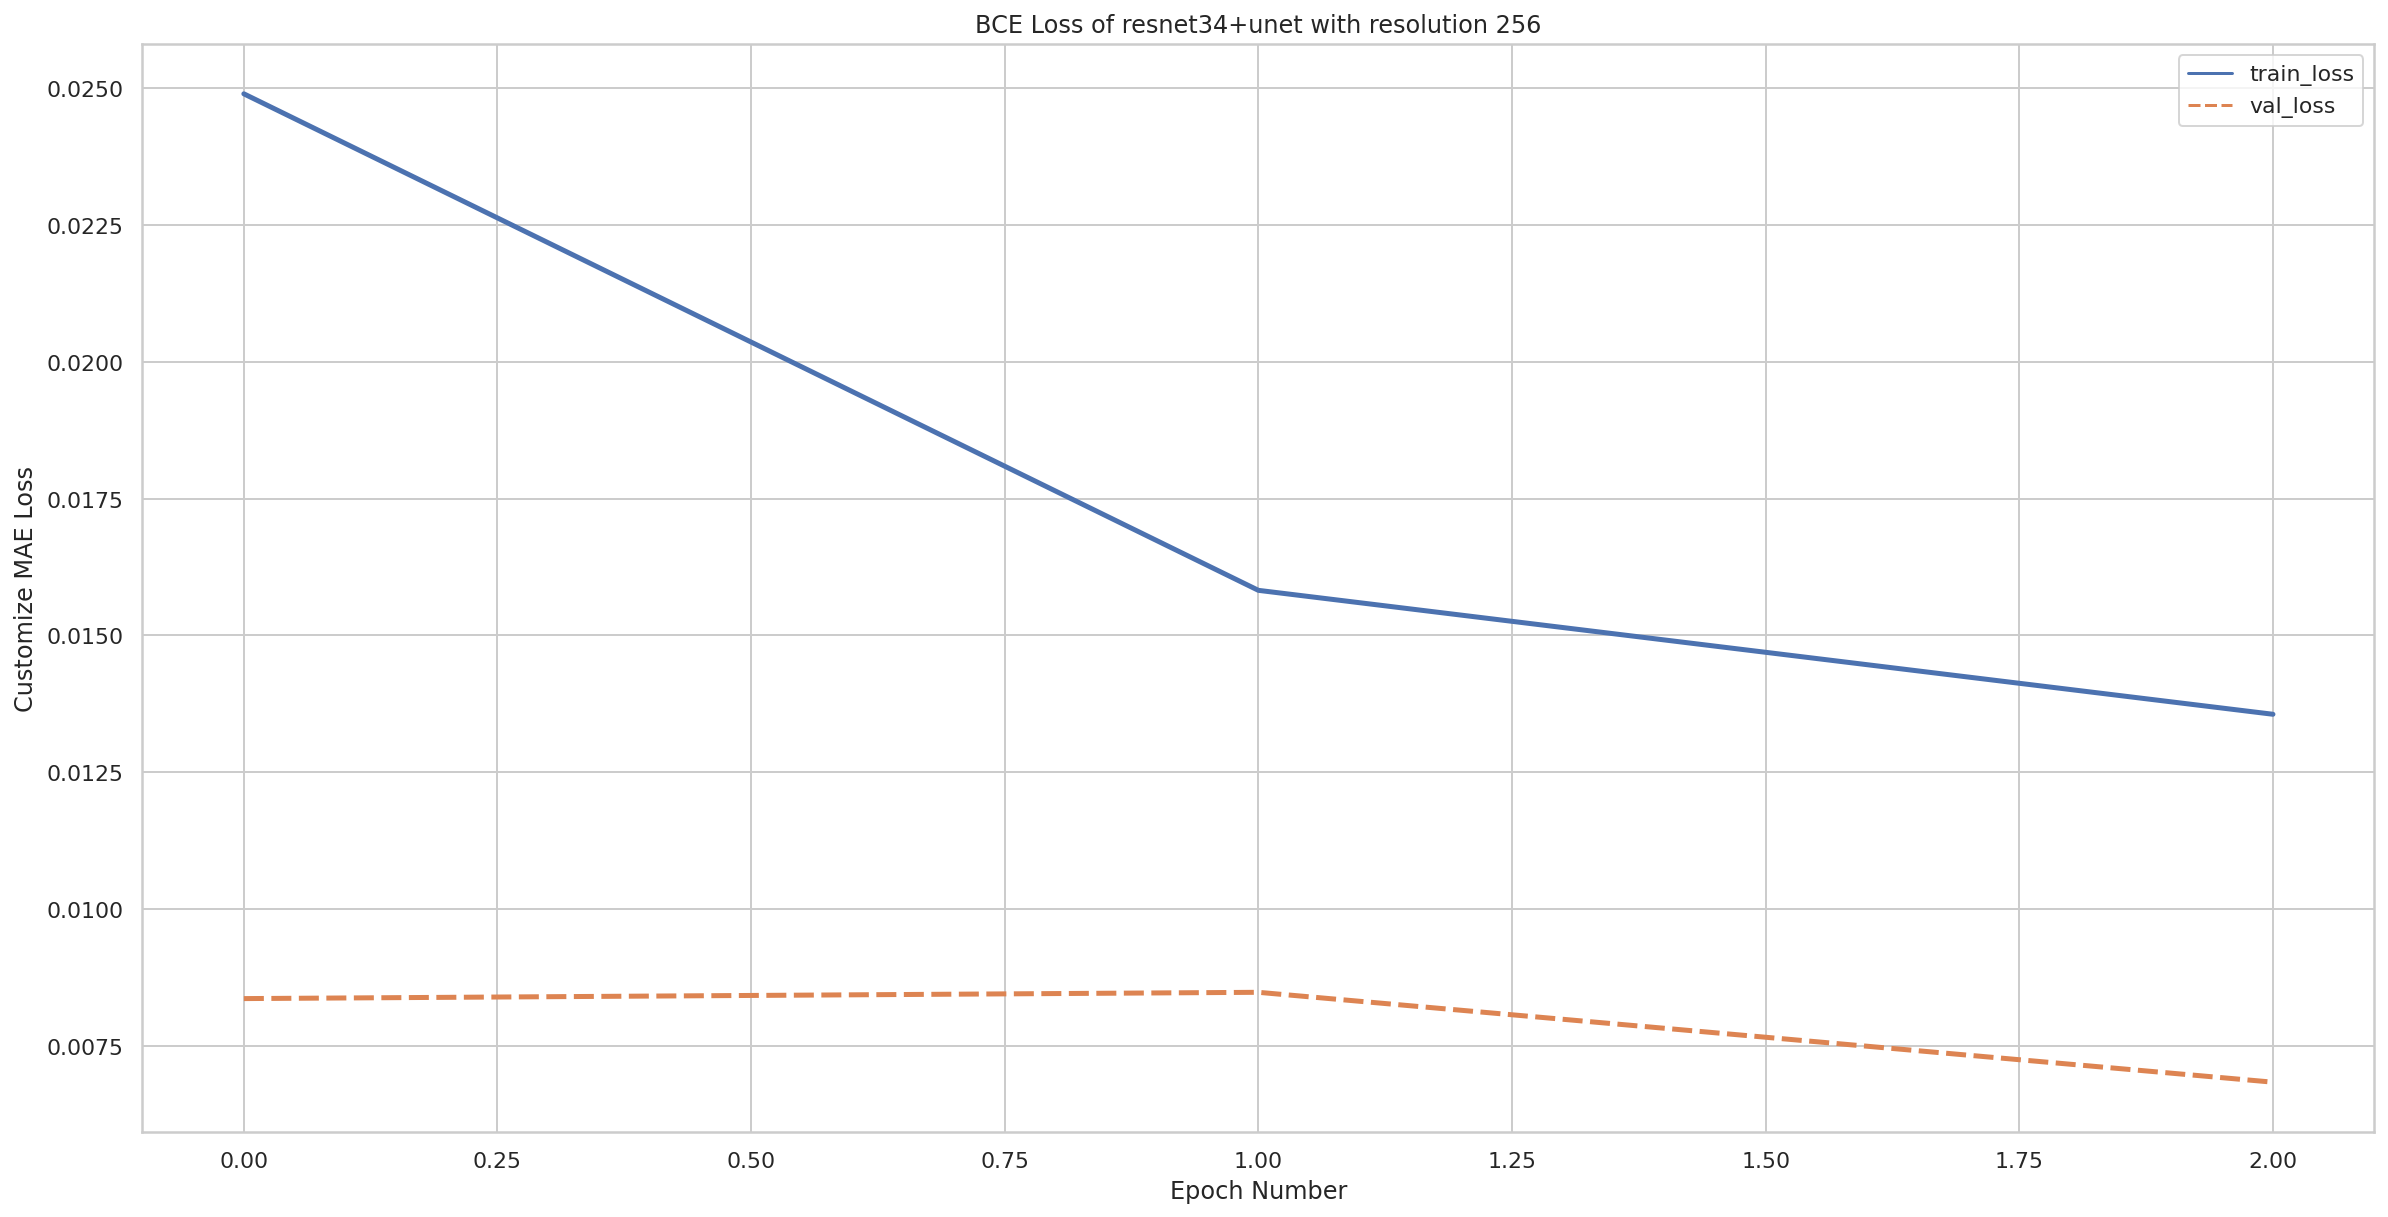

In [23]:
plot_both_loss(train_loss, val_loss, 'resnet34+unet', str(RESOLUTION))

In [24]:
def bi_mask(logit_mask, threshold):
    mask = np.where(logit_mask <= threshold, 0, 1)
    
    return mask

In [25]:
pred_1 = torch.sigmoid(logit_mask[NUM_EPOCHS - 1][0].squeeze())
pred_2 = torch.sigmoid(logit_mask[NUM_EPOCHS - 1][1].squeeze())
pred_3 = torch.sigmoid(logit_mask[NUM_EPOCHS - 1][2].squeeze())
pred_4 = torch.sigmoid(logit_mask[NUM_EPOCHS - 1][3].squeeze())

In [26]:
pred_1_bi = bi_mask(pred_1, 0.5)
pred_2_bi = bi_mask(pred_2, 0.5)
pred_3_bi = bi_mask(pred_3, 0.5)
pred_4_bi = bi_mask(pred_4, 0.5)

In [27]:
true_1 = true_mask[NUM_EPOCHS - 1][0].squeeze()
true_2 = true_mask[NUM_EPOCHS - 1][1].squeeze()
true_3 = true_mask[NUM_EPOCHS - 1][2].squeeze()
true_4 = true_mask[NUM_EPOCHS - 1][3].squeeze()


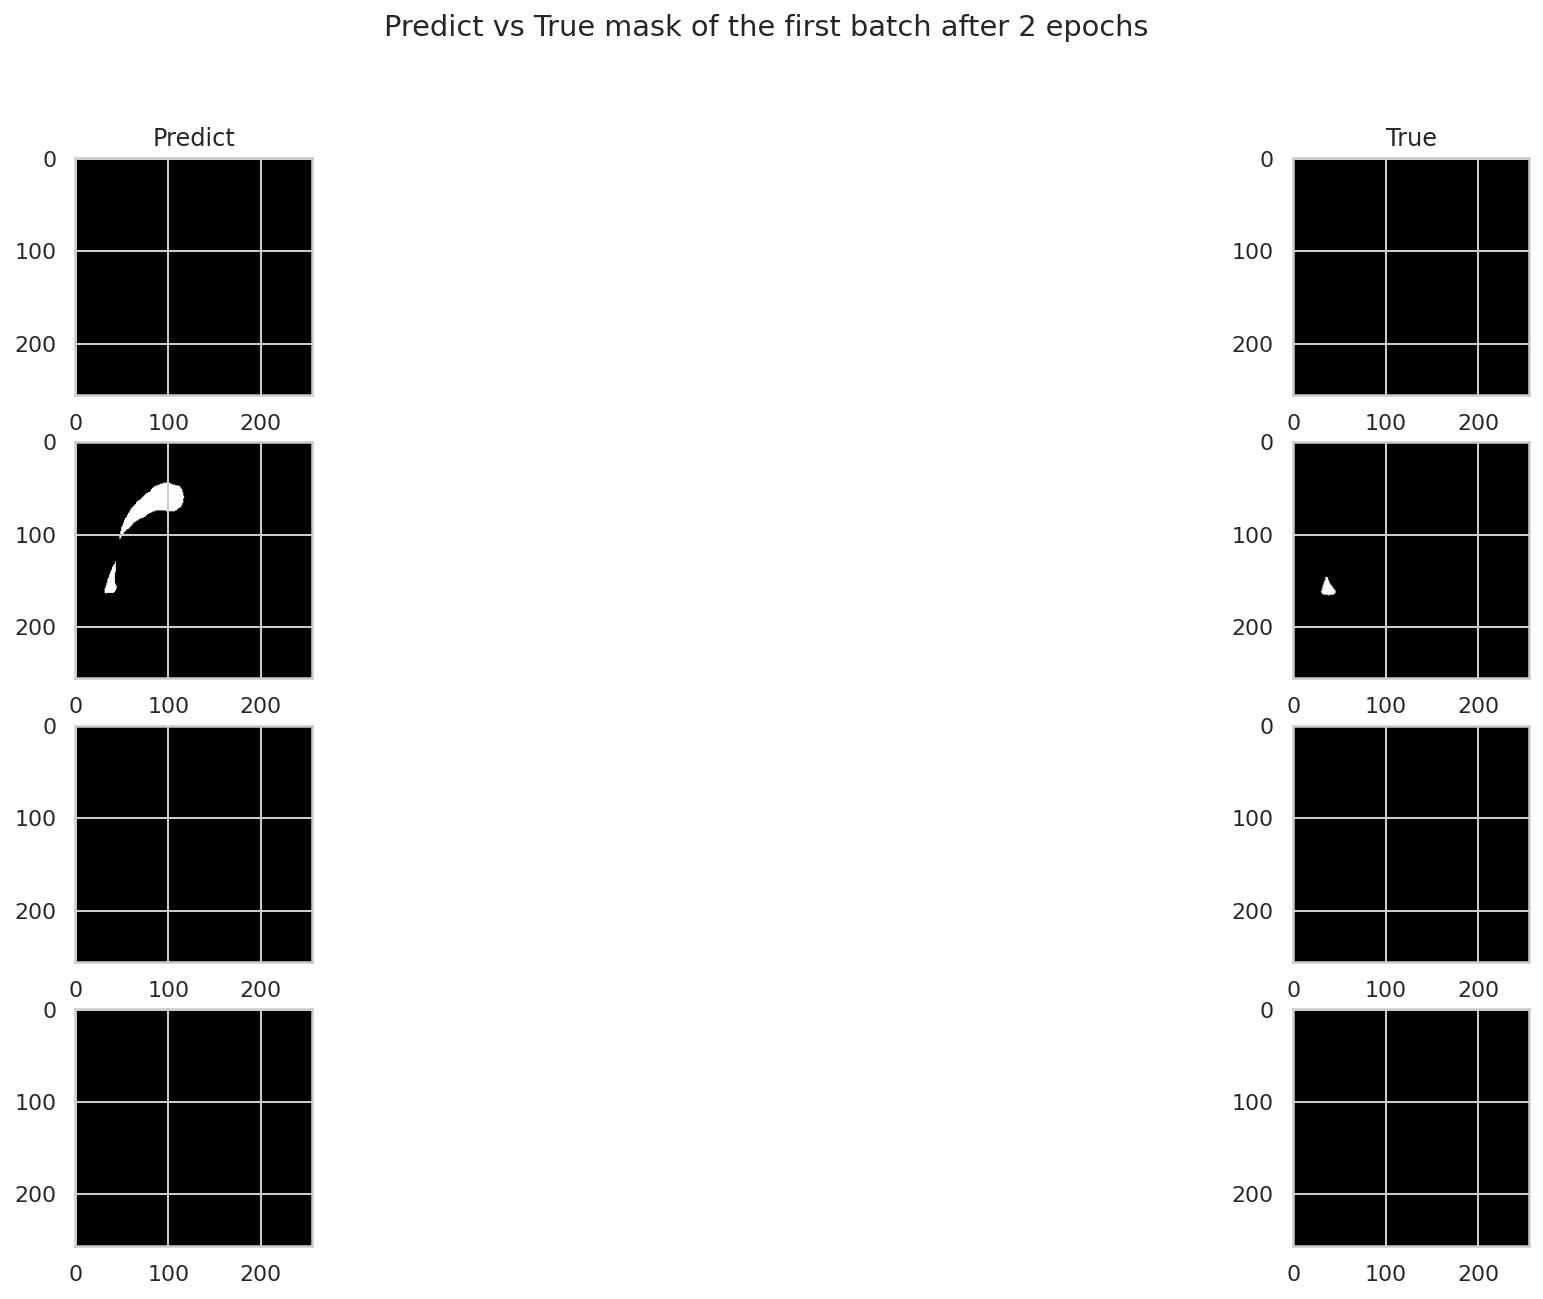

In [28]:
fig_size = (20, 10)
fig, axs = plt.subplots(4, 2, figsize = fig_size)
axs[0][0].imshow(pred_1_bi, cmap='gray')
axs[0][0].title.set_text('Predict')
axs[0][1].imshow(true_1, cmap='gray')
axs[0][1].title.set_text('True')
#plt.show()
axs[1][0].imshow(pred_2_bi, cmap='gray')
axs[1][1].imshow(true_2, cmap='gray')

#plt.show()
axs[2][0].imshow(pred_3_bi, cmap='gray')
axs[2][1].imshow(true_3, cmap='gray')

axs[3][0].imshow(pred_4_bi, cmap='gray')
axs[3][1].imshow(true_4, cmap='gray')

fig.suptitle('Predict vs True mask of the first batch after {} epochs'.format(str(NUM_EPOCHS - 1)))
plt.show()


## Test Metrics (Confusion Matrix and ROC Curve)

In [31]:
def plot_confusion_matrix(y_test, y_true, model_name, resolution):
    """
    Helper function for plotting the condusion matrix for binary outputs
    """
    
    cm = confusion_matrix(y_true, y_test)

    sns.heatmap(cm, annot=True, cmap = 'Blues', fmt="d")
    plt.title('Confusion matrix of model {} with resolution {}'.format(model_name, resolution))
    plt.xlabel('Prediction')
    plt.ylabel('True')
    plt.show()
    
def plot_roc_curve(y_test, y_true, model_name, resolution):
    """
    Helper function to plot the ROC curve
    """
    fpr, tpr, threshold = roc_curve(y_true, y_test, drop_intermediate = False)
    roc_auc = roc_auc_score(y_true, y_test)

    plt.figure(1)
    plt.plot([0, 1], [0, 1])
    plt.plot(fpr, tpr, label='{}(area = {:.3f})'.format(model_name, roc_auc))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve of model {} with resolution {}'.format(model_name, resolution))
    plt.legend(loc='best')
    plt.show()


In [93]:
def bi_mask_torch(logit_mask, threshold):
    """
    Helper function to turn a mask from sigmoid values to binary (0/1) values based on hard threshold
    Designed for test set binarization based on torch 
    """
    mask = torch.where(logit_mask <= threshold, 0, 1)
    
    return mask

In [120]:
def test_metrics(test_loader, model):
    """
    Calculate confusion matrix & auc-roc
    Return a list 
    """
    y_test = np.array([])
    y_true = np.array([])
    total_num_batch = 0
    for i, (imgs, labels) in enumerate(test_loader):
        total_num_batch += 1
        imgs, labels = imgs.to(DEVICE, dtype=torch.float), labels.to(DEVICE, dtype=torch.float)
        preds = model(imgs) # 4 x 3D tensors
#         print("Output image from the trained model: ", preds[3])
        preds_sigmoid = torch.sigmoid(preds[:, 0].squeeze())
#         print("After slicing: ", preds[:, 0][3])
        print("After sigmoid: ", preds_sigmoid)
        binarized = [bi_mask_torch(preds_sigmoid_ind, 0.5) for preds_sigmoid_ind in preds_sigmoid]
        print("After binarziation: ", binarized)
#         soft_max = nn.Softmax(dim=1)
#         print("Soft Max: ", soft_max)
#         pred_prob = soft_max(preds).detach().cpu().numpy()
#         print("pred_prob: ", pred_prob)
        
#         pred_label = np.argmax(pred_prob, axis=1)
        pred_label = [sum(map(sum,binarized_ind)).detach().cpu().numpy() for binarized_ind in binarized]
        print("Prediction Label: ", pred_label)
        true_label = labels.detach().cpu().numpy().astype(int) #2D in this way
        true_label_list = [sum(map(sum, true_label_ind[0])) for true_label_ind in true_label]
#         print("True label: ", true_label_list)
#         true_label = labels.detach().cpu().numpy().astype(int)[:, 1]
        
        y_test = np.concatenate((y_test, pred_label))
        y_true = np.concatenate((y_true, true_label))
    
    plot_confusion_matrix(y_test, y_true, 'resnet34', '256x256')
    plot_roc_curve(y_test, y_true, 'resnet34', '256x256')
    
    print('Total Number of Batch Size: ', total_num_batch)
    return y_test, y_true

In [121]:
y_test, y_true = test_metrics(test_loader, unet_model)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


After sigmoid:  tensor([[[9.5902e-03, 1.6460e-03, 1.7188e-03,  ..., 9.5859e-04,
          1.2029e-03, 7.5558e-03],
         [1.4587e-03, 1.0960e-04, 1.4500e-04,  ..., 6.6348e-05,
          8.6670e-05, 1.3640e-03],
         [9.2524e-04, 5.9071e-05, 1.0573e-04,  ..., 5.2269e-05,
          6.5374e-05, 1.1637e-03],
         ...,
         [1.2312e-03, 6.5995e-05, 7.0734e-05,  ..., 3.0525e-05,
          2.7325e-05, 5.7503e-04],
         [1.3002e-03, 6.6453e-05, 5.1446e-05,  ..., 2.0414e-05,
          2.4483e-05, 6.3602e-04],
         [2.1361e-02, 1.7019e-03, 1.2801e-03,  ..., 6.7242e-04,
          9.0923e-04, 5.3226e-03]],

        [[9.5315e-03, 1.6273e-03, 1.7227e-03,  ..., 8.7499e-04,
          1.1311e-03, 7.3522e-03],
         [1.4306e-03, 1.0464e-04, 1.4033e-04,  ..., 5.8162e-05,
          7.8781e-05, 1.3111e-03],
         [8.8768e-04, 5.3897e-05, 9.2960e-05,  ..., 4.5836e-05,
          5.9780e-05, 1.1159e-03],
         ...,
         [1.3533e-03, 7.3943e-05, 8.0495e-05,  ..., 3.0780e-05,

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 4 dimension(s)